In [1]:
import os, sys

# go up one level from the notebook dir
REPO_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
if REPO_ROOT not in sys.path:
    sys.path.insert(0, REPO_ROOT)

print("REPO_ROOT:", REPO_ROOT)

import torch
from sklearn.datasets import make_regression
from sklearn.datasets import make_friedman1
from scipy.stats import uniform
import matplotlib.pyplot as plt
import numpy as np
import csv
from torch.utils.data import DataLoader, TensorDataset

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using CUDA:", torch.cuda.get_device_name(device))
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS (Apple Metal)")
else:
    device = torch.device("cpu")
    print("Using CPU")

print("Final device:", device)

REPO_ROOT: /Users/kailashfaris/Desktop/Tufts/cs136 (StatPatt)/project/shanethomaswilliams-sngp-sandbox-179f27b
Using MPS (Apple Metal)
Final device: mps


In [2]:
def write_history_to_csv(csv_path, x_N, y_N):
    N = x_N.size
    data = [["X", "Y"]]
    for i, x in enumerate(x_N):
        data.append([x, y_N[i]])

    with open("data/"+csv_path+".csv", "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerows(data)

In [3]:
def write_history_to_csv_multivar(csv_path, x_ND, y_N):
    N = len(x_ND)
    D = len(x_ND[0])
    data_names = [f"X{d}" for d in range(D)] + ["Y"]
    data = np.column_stack((x_ND, y_N))

    with open("data/"+csv_path+".csv", "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(data_names)
        writer.writerows(data)

In [57]:
'''
Inputs:
    csv_path: filename to load from
    splits: [train_percentage, valid_percentage, test_percentage]
'''
def load_data_train(file_path, sample_size, train_percentage = 0.75, random_state=42):
    #Makes sure the splits make sense
    assert train_percentage < 1.0

    #Splots into train/validation & test filepaths
    #file_path_train = "Data/Noisy/" + dataset_name
    #file_path_test = "Data/Clean/" + dataset_name

    #Load data
    tensor_DF = torch.load(file_path)
    print(tensor_DF.keys)
    x_DF = tensor_DF["x"]
    y_D = tensor_DF["y"]

    
    # Random shuffle of row ids corresponding to all L provided examples
    D = len(x_DF)
    rng = np.random.default_rng(seed=random_state)
    shuffled_ids_D = rng.permutation(np.arange(D))

    #Train = N, Validation = V, Test = T
    #Determine N, V, T
    N = int(np.round(sample_size * (train_percentage)))
    V = sample_size - N
    assert D >= N + V

    #Make x_data
    x_train_NF = x_DF[shuffled_ids_D[0:N]].unsqueeze(-1)
    x_valid_VF = x_DF[shuffled_ids_D[N:N+V]].unsqueeze(-1)

    #Make SNGP y_data
    y_SNGP_train_N1 = y_D[shuffled_ids_D[0:N]]
    y_SNGP_valid_V1 = y_D[shuffled_ids_D[N:N+V]]

    #Make GP y_data
    y_GP_train_N = y_SNGP_train_N1.unsqueeze(-1)
    y_GP_valid_V = y_SNGP_valid_V1.unsqueeze(-1)

    GP_train_dataset = TensorDataset(x_train_NF, y_GP_train_N)

    # TODO return both x_train_MF and x_test_NF
    return x_train_NF, x_valid_VF, y_SNGP_train_N1, y_SNGP_valid_V1, y_GP_train_N, y_GP_valid_V

In [63]:
load_data_train("Data/Noisy/CrazySin", 10, 0.7, random_state=12)

<built-in method keys of dict object at 0x139930080>


(tensor([ 2.2707,  2.9190, -1.3103, -1.7517,  2.1050, -0.3965, -1.2833],
        dtype=torch.float64),
 tensor([ 0.6306, -0.6176, -0.1952], dtype=torch.float64),
 tensor([ 0.2952, -0.8319,  0.5033,  0.0936,  1.2525,  1.4720,  0.5052],
        dtype=torch.float64),
 tensor([ 0.3166,  0.4625, -1.2587], dtype=torch.float64),
 tensor([[ 0.2952],
         [-0.8319],
         [ 0.5033],
         [ 0.0936],
         [ 1.2525],
         [ 1.4720],
         [ 0.5052]], dtype=torch.float64),
 tensor([[ 0.3166],
         [ 0.4625],
         [-1.2587]], dtype=torch.float64))

# Full Regressions

### Linear Regression

In [ ]:
N = 100_000
noise = 0.1
split = [0.3, 0.4, 0.3]
rng = np.random.default_rng(seed=42)
X1 = (rng.normal(loc=-0.8, scale=0.1, size=int(N*split[0])))
X2 = (rng.normal(loc=0.4, scale=0.07, size=int(N*split[1])))
X3 = (rng.normal(loc=1.5, scale=0.1, size=int(N*split[2])))
X = np.concatenate((X1, X2, X3))
rng.shuffle(X)
#print(X)
y = 10 * np.sin(np.pi * (X ** 2)) + (20 * ((X - 0.5) ** 2)) + (15 * X)
#y = y + (noise * rng.normal(size = N))
plt.plot(X, y, 'ro')
plt.xlabel("x")
plt.ylabel("y")
plt.title("Friedman sample data")
write_history_to_csv("friedman_sparse_N="+str(N), X, y)

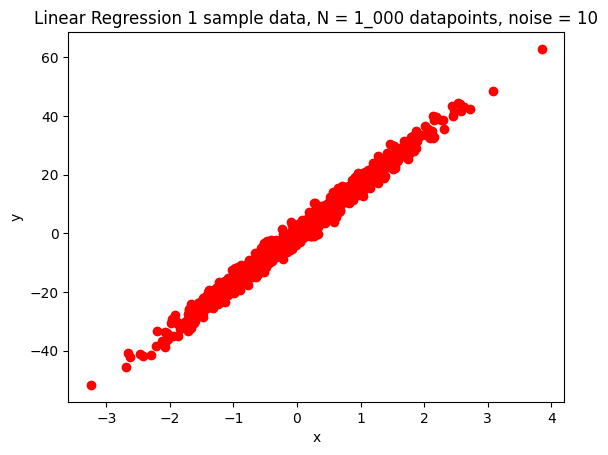

In [5]:
N = 100_000
noise = 2
#Note we don't control the equations of these slopes
X, y = make_regression(n_samples=1_000, n_features=1, noise=noise, random_state=42)
#print(X)
#print(y)
plt.plot(X, y, 'ro')
plt.xlabel("x")
plt.ylabel("y")
plt.title("Linear Regression 1 sample data, N = 1_000 datapoints, noise = 10")
write_history_to_csv("regression_N="+str(N), X, y)

### Sinusoidal

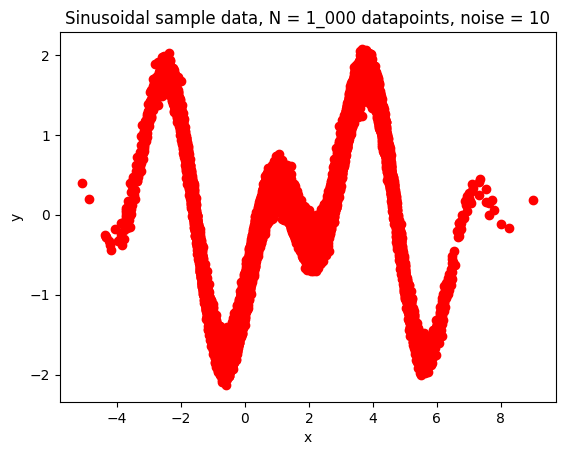

In [6]:
N = 100_000
mean = 1.5
stdev = 1.5
noise = 0.1
rng = np.random.default_rng(seed=42)
X = (rng.normal(loc=mean, scale=stdev, size=N))
#print(X)
y = np.sin(2 * X) - np.cos(X)
y = y + (noise * rng.normal(size = N))
plt.plot(X, y, 'ro')
plt.xlabel("x")
plt.ylabel("y")
plt.title("Sinusoidal sample data, N = 1_000 datapoints, noise = 10")
write_history_to_csv("sinusoidal_N="+str(N), X, y)

### Sine crazy

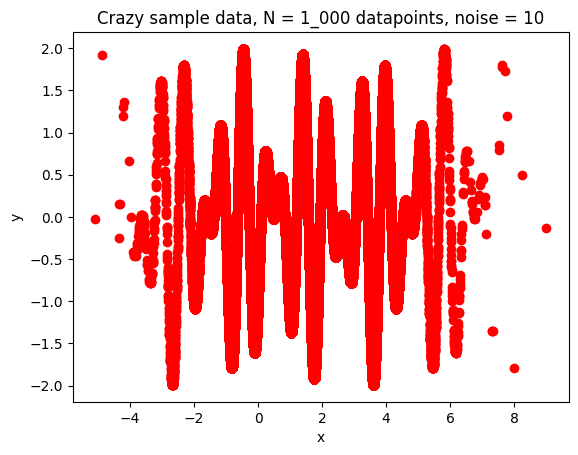

In [22]:
N = 100_000
mean = 1.5
stdev = 1.5
noise = 0.0
rng = np.random.default_rng(seed=42)
X = (rng.normal(loc=mean, scale=stdev, size=N))
#print(X)
y = np.sin(10 * X) - np.cos(7 * X)
y = y + (noise * rng.normal(size = N))
plt.plot(X, y, 'ro')
plt.xlabel("x")
plt.ylabel("y")
plt.title("Crazy sample data, N = 1_000 datapoints, noise = 10")
write_history_to_csv("crazy_N="+str(N), X, y)

### Friedman

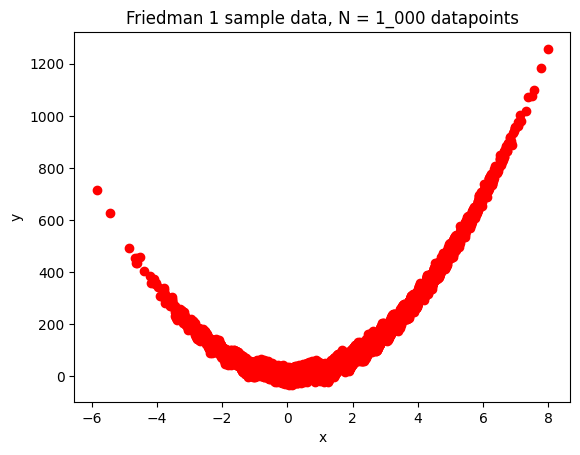

In [8]:
N = 100_000
mean = 1.5
stdev = 1.5
noise = 10
X = (np.random.normal(loc=mean, scale=stdev, size=N))
#print(X)
y = 10 * np.sin(np.pi * (X ** 2)) + (20 * ((X - 0.5) ** 2)) + (15 * X)
y = y + (noise * np.random.normal(size = N))
plt.plot(X, y, 'ro')
plt.xlabel("x")
plt.ylabel("y")
plt.title("Friedman 1 sample data, N = 1_000 datapoints")
write_history_to_csv("friedman_N="+str(N), X, y)

### Friedman 5 variables 

In [9]:
N = 100_000
mean = 1.5
stdev = 1.5
noise = 10
num_variables = 5
X, y = make_friedman1(n_samples=N, n_features=5, noise=noise, random_state=42)
#plt.plot(X, y, 'ro')
#plt.xlabel("x")
#plt.ylabel("y")
#plt.title("Friedman 1 sample data, N = 1_000 datapoints")
fileName = "friedman_var="+str(num_variables)+"_N="+str(N)
write_history_to_csv_multivar(fileName, X, y)

# Sparse Regressions

### Linear Regression

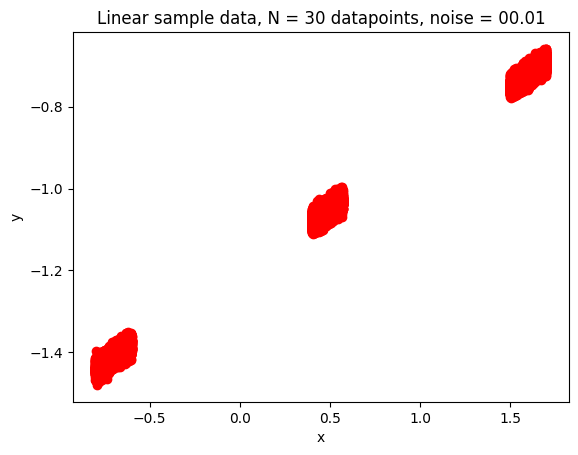

In [16]:
N = 100_000
noise = 0.01
split = [0.3, 0.4, 0.3]
rng = np.random.default_rng(seed=42)
X1 = uniform.rvs(loc=-0.8, scale=0.2, size=int(N*split[0]))#(rng.normal(loc=-0.8, scale=0.1, size=int(N*split[0])))
X2 = (uniform.rvs(loc=0.4, scale=0.17, size=int(N*split[1])))
X3 = (uniform.rvs(loc=1.5, scale=0.2, size=int(N*split[2])))
X = np.concatenate((X1, X2, X3))
rng.shuffle(X)
#print(X)
y = 0.3 * X - 1.2
y = y + (noise * np.random.normal(size = X.size))
plt.plot(X, y, 'ro')
plt.xlabel("x")
plt.ylabel("y")
plt.title("Linear sample data, N = 30 datapoints, noise = 00.01")
write_history_to_csv("regression_sparse_N="+str(N), X, y)

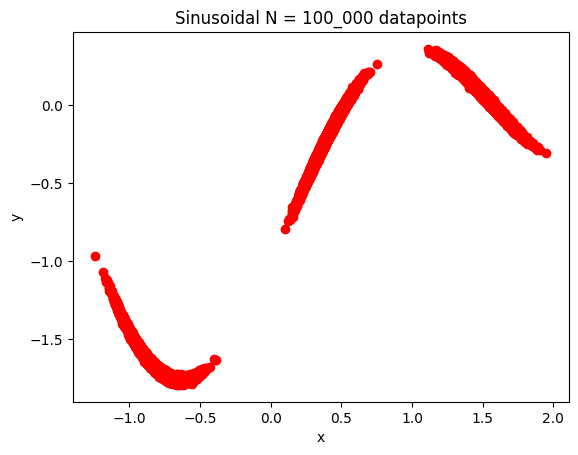

In [20]:
N = 100_000
noise = 0.01
split = [0.3, 0.4, 0.3]
rng = np.random.default_rng(seed=42)
X1 = (rng.normal(loc=-0.8, scale=0.1, size=int(N*split[0])))
X2 = (rng.normal(loc=0.4, scale=0.07, size=int(N*split[1])))
X3 = (rng.normal(loc=1.5, scale=0.1, size=int(N*split[2])))
X = np.concatenate((X1, X2, X3))
rng.shuffle(X)
#print(X)
y = np.sin(2 * X) - np.cos(X)
y = y + (noise * np.random.normal(size = N))
plt.plot(X, y, 'ro')
plt.xlabel("x")
plt.ylabel("y")
plt.title("Sinusoidal N = 100_000 datapoints")
write_history_to_csv("sinusoidal_sparse_N="+str(N), X, y)

### Friedman

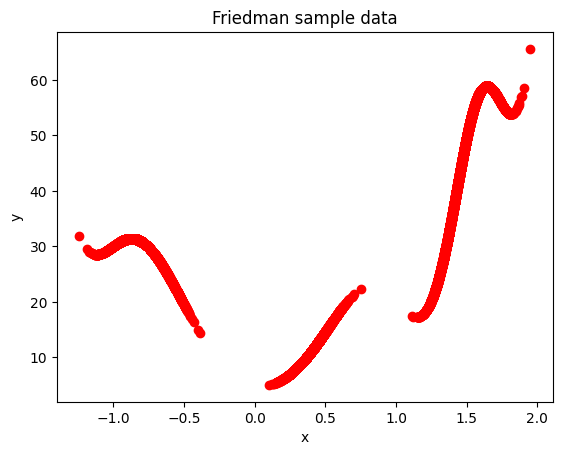

In [12]:
N = 100_000
noise = 0.1
split = [0.3, 0.4, 0.3]
rng = np.random.default_rng(seed=42)
X1 = (rng.normal(loc=-0.8, scale=0.1, size=int(N*split[0])))
X2 = (rng.normal(loc=0.4, scale=0.07, size=int(N*split[1])))
X3 = (rng.normal(loc=1.5, scale=0.1, size=int(N*split[2])))
X = np.concatenate((X1, X2, X3))
rng.shuffle(X)
#print(X)
y = 10 * np.sin(np.pi * (X ** 2)) + (20 * ((X - 0.5) ** 2)) + (15 * X)
#y = y + (noise * rng.normal(size = N))
plt.plot(X, y, 'ro')
plt.xlabel("x")
plt.ylabel("y")
plt.title("Friedman sample data")
write_history_to_csv("friedman_sparse_N="+str(N), X, y)

In [13]:
def split_into_train_and_test(x_all_LF, frac_test=0.5, random_state=None):
    ''' Divide provided array into train and test sets along first dimension

    User can provide random number generator object to ensure reproducibility.

    Args
    ----
    x_all_LF : 2D np.array, shape = (n_total_examples, n_features) (L, F)
        Each row is a feature vector
    frac_test : float, fraction between 0 and 1
        Indicates fraction of all L examples to allocate to the "test" set
        Returned test set will round UP if frac_test * L is not an integer.
        e.g. if L = 10 and frac_test = 0.31, then test set has N=4 examples
    random_state : np.random.RandomState instance or integer or None
        If int, will create RandomState instance with provided value as seed
        If None, defaults to current numpy random number generator np.random.

    Returns
    -------
    x_train_MF : 2D np.array, shape = (n_train_examples, n_features) (M, F)
        Each row is a feature vector
        Should be a separately allocated array, NOT a view of any input array

    x_test_NF : 2D np.array, shape = (n_test_examples, n_features) (N, F)
        Each row is a feature vector
        Should be a separately allocated array, NOT a view of any input array

    Post Condition
    --------------
    This function should be side-effect free. Provided input array x_all_LF
    should not change at all (not be shuffled, etc.)
    '''
    if random_state is None:
        random_state = np.random
    elif isinstance(random_state, int):
        random_state = np.random.RandomState(int(random_state))
    if not hasattr(random_state, 'rand'):
        raise ValueError("Not a valid random number generator")

    # Random shuffle of row ids corresponding to all L provided examples
    L, F = x_all_LF.shape
    shuffled_ids_L = random_state.permutation(np.arange(L))
    #print(shuffled_ids_L)

    # Determine the number of test examples N
    N = int(np.ceil(L * float(frac_test)))
    # Keep remaining M examples as training
    M = L - N

    # TODO use the first M row ids in shuffled_ids_L to make x_train_MF
    x_train_MF = np.zeros((M,F))
    for i in range(M):
        shuffledPos = shuffled_ids_L[i]
        train_row_F = x_all_LF[shuffledPos]
        x_train_MF[i] = train_row_F

    # TODO use the remaining N row ids to make x_test_NF
    x_test_NF = np.zeros((N,F))
    for i in range(N):
        shuffledPos = shuffled_ids_L[M+i]
        test_row_F = x_all_LF[shuffledPos]
        x_test_NF[i] = test_row_F
    # HINT Use integer indexing in the lab notebook on numerical python

    # TODO return both x_train_MF and x_test_NF
    return x_train_MF, x_test_NF

[0.90155223 0.94813454 0.13162775 0.58668916 0.32511808 0.89251899
 0.67758371 0.16507958 0.36412696 0.14156596 0.3458106  0.20297152
 0.76216315 0.31732598 0.32749679 0.49393185 0.50776012 0.54775404
 0.10242375 0.29162593 0.06695834 0.95784459 0.3621662  0.83559392
 0.33723816 0.4072727  0.31386084 0.52071215 0.04894795 0.75442972
 0.94516019 0.11822676 0.86340018 0.77671373 0.81619817 0.41834557
 0.62693935 0.73771078 0.06634176 0.7701648  0.82028159 0.14109857
 0.51601542 0.5614366  0.19030959 0.22923905 0.45856502 0.16925755
 0.00915325 0.12429367 0.27465065 0.57381912 0.05100925 0.07979451
 0.02485517 0.18972713 0.21940676 0.46519516 0.06406069 0.6901812
 0.25228353 0.72631139 0.58537408 0.70761438 0.48453455 0.97034791
 0.88485084 0.77698145 0.9823456  0.4590361  0.16169584 0.73547432
 0.97080971 0.09396963 0.66574908 0.14440971 0.15805508 0.54619463
 0.19354259 0.52381158 0.1021847  0.57420097 0.53621572 0.43038666
 0.61194524 0.12976229 0.93978746 0.72516675 0.1270151  0.47155